

****SUMMARY****
By examining these insights, we can conclude that the overall value trend is decreasing by -0.0151 from start to end. The 3-month moving average indicates a downward trend, highlighting the general direction of the data.

Significant fluctuations are evident, with the largest increase observed between February 2024 to March 2024 (slope: 0.0043) and the largest decrease from July 2022 to August 2022 (slope: -0.0039).

Additionally, A seasonal pattern repeating every 2 months has been detected, with a general decrease in trend.

**Trend for 2024:** The trend has stabilized since the beginning of the year.


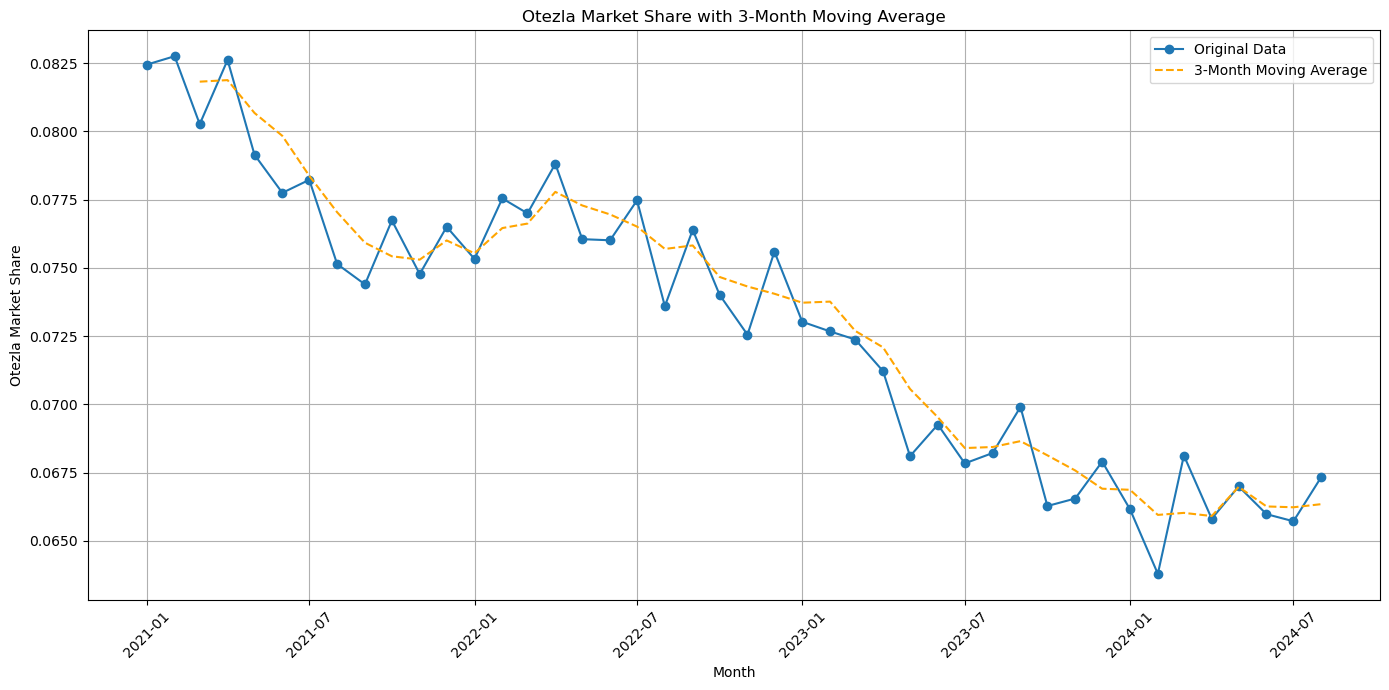

In [335]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from scipy.stats import zscore

# Load data - Otezla Market Share
data = pd.DataFrame({
    'Month': pd.to_datetime([
        '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10',
        '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08',
        '2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06',
        '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12', '2024-01', '2024-02', '2024-03', '2024-04',
        '2024-05', '2024-06', '2024-07', '2024-08']),
    'Value': [
         0.082445, 0.082753, 0.080264, 0.082615, 0.079142, 0.077747, 0.078224, 0.075140,
        0.074393, 0.076735, 0.074772, 0.076502, 0.075325, 0.077543, 0.076995, 0.078809,
        0.076050, 0.076009, 0.077473, 0.073594, 0.076392, 0.074007, 0.072550, 0.075593,
        0.073023, 0.072670, 0.072373, 0.071214, 0.068100, 0.069256, 0.067834, 0.068214,
        0.069902, 0.066273, 0.066548, 0.067900, 0.066154, 0.063788, 0.068123, 0.065807,
        0.066991, 0.065975, 0.065714, 0.067335
    ]
})
# Set the 'Month' column as the index for easier manipulation
data.set_index('Month', inplace=True)

# Compute the autocorrelation function (ACF)
lag_acf = acf(data['Value'], nlags=24)

# Function to detect seasonality or outliers dynamically
def detect_seasonality_or_outlier(acf_values, data, threshold=0.2, min_lag=2, z_threshold=2.0):
    peaks = [i for i in range(min_lag, len(acf_values)) if acf_values[i] > threshold]
    if not peaks:
        return None, None

    peak_acf = max(peaks, key=lambda x: acf_values[x])

    # Group data by month and calculate mean
    monthly_means = data.groupby(data.index.month)['Value'].mean()

    # Calculate z-scores for monthly means to identify outliers
    monthly_zscores = zscore(monthly_means)

    # Check if any month is an outlier based on z-score threshold
    outlier_month = monthly_means.index[np.argmax(monthly_zscores)]
    if monthly_zscores.max() > z_threshold:
        # Return the month name instead of number
        return peak_acf, f"outlier in {pd.Timestamp(2024, outlier_month, 1).strftime('%B')}"

    # If no outliers, determine seasonality pattern
    seasonal_values = data['Value'][::peak_acf]
    if len(seasonal_values) < 2:
        return peak_acf, None

    seasonal_trend = "increase" if seasonal_values.diff().mean() > 0 else "decrease"
    return peak_acf, seasonal_trend

# Detect seasonality or outlier dynamically
seasonal_period, seasonal_trend = detect_seasonality_or_outlier(lag_acf, data)

# Function to calculate 3-month moving average of slopes for a given year
def moving_average_slopes(data, year, window=3):
    # Filter the data for the specified year
    data_year = data[data.index.year == year]
    
    # Calculate the slopes for each consecutive period in the selected year
    slopes = np.diff(data_year['Value'])
    
    # Calculate the moving average of the slopes
    ma_slopes = np.convolve(slopes, np.ones(window) / window, mode='valid')
    
    # Check if the slope of the moving average approaches zero
    if np.abs(ma_slopes.mean()) < 0.0001:
        ma_slope_trend = "The trend has stabilized since the beginning of the year"
    elif ma_slopes.mean() > 0:
        ma_slope_trend = "The trend has increased since the beginning of the year"
    else:
        ma_slope_trend = "The trend has decreased since the beginning of the year"
    
    return ma_slopes, ma_slope_trend

# Trend analysis and summary function
def trend_analysis(data, seasonal_period, seasonal_trend):
    x = np.arange(len(data))
    y = data['Value'].values
    slope = (y[-1] - y[0]) / (x[-1] - x[0])
    direction = "increasing" if slope > 0 else "decreasing" if slope < 0 else "stable"

    # Calculate total change from start to end
    total_change = y[-1] - y[0]
    
    slopes = [data['Value'].iloc[i] - data['Value'].iloc[i-1] for i in range(1, len(data))]
    max_increase = max(slopes)
    max_decrease = min(slopes)
    max_increase_periods = [(data.index[i].strftime('%B %Y'), data.index[i+1].strftime('%B %Y')) for i, slope in enumerate(slopes) if slope == max_increase]
    max_decrease_periods = [(data.index[i].strftime('%B %Y'), data.index[i+1].strftime('%B %Y')) for i, slope in enumerate(slopes) if slope == max_decrease]

    max_increase_periods_str = ', '.join([f"{start} to {end}" for start, end in max_increase_periods])
    max_decrease_periods_str = ', '.join([f"{start} to {end}" for start, end in max_decrease_periods])

    # Moving average calculation
    ma_window = 3  # 3-month moving average
    moving_avg = np.convolve(data['Value'].values, np.ones(ma_window) / ma_window, mode='valid')
    moving_avg_trend = (moving_avg[-1] - moving_avg[0]) / (len(moving_avg) - 1)
    ma_trend_direction = "upward" if moving_avg_trend > 0 else "downward" if moving_avg_trend < 0 else "stable"

    # Additional moving average slope analysis for the latest year dynamically
    latest_year = data.index.year.max()
    ma_slopes_latest, ma_slope_trend_latest = moving_average_slopes(data, year=latest_year)

    # Summary
    if seasonal_period:
        if seasonal_trend.startswith('outlier'):
            seasonal_summary = f"An outlier has been detected in {seasonal_trend.split()[-1]} with a significant pattern repeating every {seasonal_period} months."
        else:
            seasonal_summary = f"A seasonal pattern repeating every {seasonal_period} months has been detected, with a general {seasonal_trend} in trend."
    else:
        seasonal_summary = "No seasonal pattern was detected, indicating an outlier."

    summary = (
        f"\n\n****SUMMARY****\nBy examining these insights, we can conclude that the overall value trend is "
        f"{direction} by {total_change:.4f} from start to end. The 3-month moving average indicates a {ma_trend_direction} trend, highlighting the general direction "
        f"of the data.\n\nSignificant fluctuations are evident, with the largest increase observed between "
        f"{max_increase_periods_str} (slope: {max_increase:.4f}) and the largest "
        f"decrease from {max_decrease_periods_str} (slope: {max_decrease:.4f})."
        f"\n\nAdditionally, {seasonal_summary}\n\n"
        f"**Trend for {latest_year}:** {ma_slope_trend_latest}."
    )

    return summary

# Get the summary report
summary = trend_analysis(data, seasonal_period, seasonal_trend)
print(summary)

# Define ma_window before plotting
ma_window = 3  # 3-month moving average
moving_avg = np.convolve(data['Value'].values, np.ones(ma_window) / ma_window, mode='valid')

# Plot the data and moving average
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Value'], label='Original Data', marker='o')
plt.plot(data.index[ma_window-1:], moving_avg, label='3-Month Moving Average', linestyle='--', color='orange')
plt.title('Otezla Market Share with 3-Month Moving Average')
plt.xlabel('Month')
plt.ylabel('Otezla Market Share')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



****SUMMARY****
By examining these insights, we can conclude that the overall value trend is increasing by 0.0493 from start to end. The 3-month moving average indicates a upward trend, highlighting the general direction of the data.

Significant fluctuations are evident, with the largest increase observed between July 2022 to August 2022 (slope: 0.1317) and the largest decrease from June 2022 to July 2022 (slope: -0.1951).

Additionally, A seasonal pattern repeating every 2 months has been detected, with a general increase in trend.

**Trend for 2024:** The trend has increased since the beginning of the year.


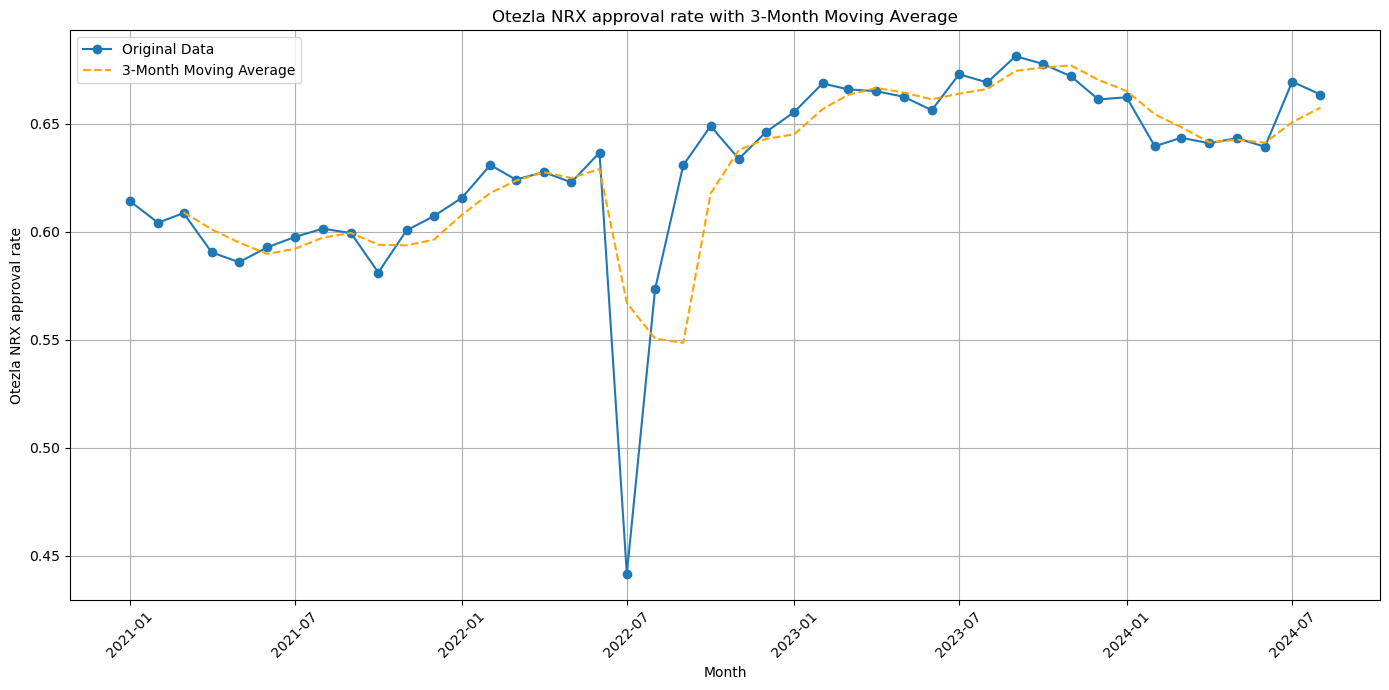

In [337]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from scipy.stats import zscore

# Load data - Otezla NRX approval rate
data = pd.DataFrame({
    'Month': pd.to_datetime([
        '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10',
        '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08',
        '2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06',
        '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12', '2024-01', '2024-02', '2024-03', '2024-04',
        '2024-05', '2024-06', '2024-07', '2024-08']),
    'Value': [
        0.61417213, 0.604131535, 0.608632747, 0.590397396, 0.585851249, 0.592739726, 0.597486115, 0.601378518, 0.599316595,
        0.581071377, 0.60057554, 0.607168666, 0.61573472, 0.630873357, 0.624114299, 0.627539796, 0.622835151, 0.636592425, 
        0.441525896, 0.573272416, 0.630753667, 0.648900063, 0.633712308, 0.646197694, 0.65542055, 0.66864711, 0.665893271,
        0.665039188, 0.6624885, 0.656264501, 0.672882259, 0.669090909, 0.681241565, 0.677698017, 0.67190499, 0.661229458,
        0.662228451, 0.6395536, 0.643461796, 0.640921558, 0.643305826, 0.639287532, 0.669458953, 0.663475106
    ]
})
# Set the 'Month' column as the index for easier manipulation
data.set_index('Month', inplace=True)

# Compute the autocorrelation function (ACF)
lag_acf = acf(data['Value'], nlags=24)

# Function to detect seasonality or outliers dynamically
def detect_seasonality_or_outlier(acf_values, data, threshold=0.2, min_lag=2, z_threshold=2.0):
    peaks = [i for i in range(min_lag, len(acf_values)) if acf_values[i] > threshold]
    if not peaks:
        return None, None

    peak_acf = max(peaks, key=lambda x: acf_values[x])

    # Group data by month and calculate mean
    monthly_means = data.groupby(data.index.month)['Value'].mean()

    # Calculate z-scores for monthly means to identify outliers
    monthly_zscores = zscore(monthly_means)

    # Check if any month is an outlier based on z-score threshold
    outlier_month = monthly_means.index[np.argmax(monthly_zscores)]
    if monthly_zscores.max() > z_threshold:
        # Return the month name instead of number
        return peak_acf, f"outlier in {pd.Timestamp(2024, outlier_month, 1).strftime('%B')}"

    # If no outliers, determine seasonality pattern
    seasonal_values = data['Value'][::peak_acf]
    if len(seasonal_values) < 2:
        return peak_acf, None

    seasonal_trend = "increase" if seasonal_values.diff().mean() > 0 else "decrease"
    return peak_acf, seasonal_trend

# Detect seasonality or outlier dynamically
seasonal_period, seasonal_trend = detect_seasonality_or_outlier(lag_acf, data)

# Function to calculate 3-month moving average of slopes for a given year
def moving_average_slopes(data, year, window=3):
    # Filter the data for the specified year
    data_year = data[data.index.year == year]
    
    # Calculate the slopes for each consecutive period in the selected year
    slopes = np.diff(data_year['Value'])
    
    # Calculate the moving average of the slopes
    ma_slopes = np.convolve(slopes, np.ones(window) / window, mode='valid')
    
    # Check if the slope of the moving average approaches zero
    if np.abs(ma_slopes.mean()) < 0.0001:
        ma_slope_trend = "The trend has stabilized since the beginning of the year"
    elif ma_slopes.mean() > 0:
        ma_slope_trend = "The trend has increased since the beginning of the year"
    else:
        ma_slope_trend = "The trend has decreased since the beginning of the year"
    
    return ma_slopes, ma_slope_trend

# Trend analysis and summary function
def trend_analysis(data, seasonal_period, seasonal_trend):
    x = np.arange(len(data))
    y = data['Value'].values
    slope = (y[-1] - y[0]) / (x[-1] - x[0])
    direction = "increasing" if slope > 0 else "decreasing" if slope < 0 else "stable"

    # Calculate total change from start to end
    total_change = y[-1] - y[0]
    
    slopes = [data['Value'].iloc[i] - data['Value'].iloc[i-1] for i in range(1, len(data))]
    max_increase = max(slopes)
    max_decrease = min(slopes)
    max_increase_periods = [(data.index[i].strftime('%B %Y'), data.index[i+1].strftime('%B %Y')) for i, slope in enumerate(slopes) if slope == max_increase]
    max_decrease_periods = [(data.index[i].strftime('%B %Y'), data.index[i+1].strftime('%B %Y')) for i, slope in enumerate(slopes) if slope == max_decrease]

    max_increase_periods_str = ', '.join([f"{start} to {end}" for start, end in max_increase_periods])
    max_decrease_periods_str = ', '.join([f"{start} to {end}" for start, end in max_decrease_periods])

    # Moving average calculation
    ma_window = 3  # 3-month moving average
    moving_avg = np.convolve(data['Value'].values, np.ones(ma_window) / ma_window, mode='valid')
    moving_avg_trend = (moving_avg[-1] - moving_avg[0]) / (len(moving_avg) - 1)
    ma_trend_direction = "upward" if moving_avg_trend > 0 else "downward" if moving_avg_trend < 0 else "stable"

    # Additional moving average slope analysis for the latest year dynamically
    latest_year = data.index.year.max()
    ma_slopes_latest, ma_slope_trend_latest = moving_average_slopes(data, year=latest_year)

    # Summary
    if seasonal_period:
        if seasonal_trend.startswith('outlier'):
            seasonal_summary = f"An outlier has been detected in {seasonal_trend.split()[-1]} with a significant pattern repeating every {seasonal_period} months."
        else:
            seasonal_summary = f"A seasonal pattern repeating every {seasonal_period} months has been detected, with a general {seasonal_trend} in trend."
    else:
        seasonal_summary = "No seasonal pattern was detected, indicating an outlier."

    summary = (
        f"\n\n****SUMMARY****\nBy examining these insights, we can conclude that the overall value trend is "
        f"{direction} by {total_change:.4f} from start to end. The 3-month moving average indicates a {ma_trend_direction} trend, highlighting the general direction "
        f"of the data.\n\nSignificant fluctuations are evident, with the largest increase observed between "
        f"{max_increase_periods_str} (slope: {max_increase:.4f}) and the largest "
        f"decrease from {max_decrease_periods_str} (slope: {max_decrease:.4f})."
        f"\n\nAdditionally, {seasonal_summary}\n\n"
        f"**Trend for {latest_year}:** {ma_slope_trend_latest}."
    )

    return summary

# Get the summary report
summary = trend_analysis(data, seasonal_period, seasonal_trend)
print(summary)

# Define ma_window before plotting
ma_window = 3  # 3-month moving average
moving_avg = np.convolve(data['Value'].values, np.ones(ma_window) / ma_window, mode='valid')

# Plot the data and moving average
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Value'], label='Original Data', marker='o')
plt.plot(data.index[ma_window-1:], moving_avg, label='3-Month Moving Average', linestyle='--', color='orange')
plt.title('Otezla NRX approval rate with 3-Month Moving Average')
plt.xlabel('Month')
plt.ylabel('Otezla NRX approval rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



****SUMMARY****
By examining these insights, we can conclude that the overall value trend is decreasing by -0.0388 from start to end. The 3-month moving average indicates a downward trend, highlighting the general direction of the data.

Significant fluctuations are evident, with the largest increase observed between March 2023 to April 2023 (slope: 0.0014) and the largest decrease from May 2023 to June 2023 (slope: -0.0030).

Additionally, A seasonal pattern repeating every 2 months has been detected, with a general decrease in trend.

**Trend for 2024:** The trend has decreased since the beginning of the year.


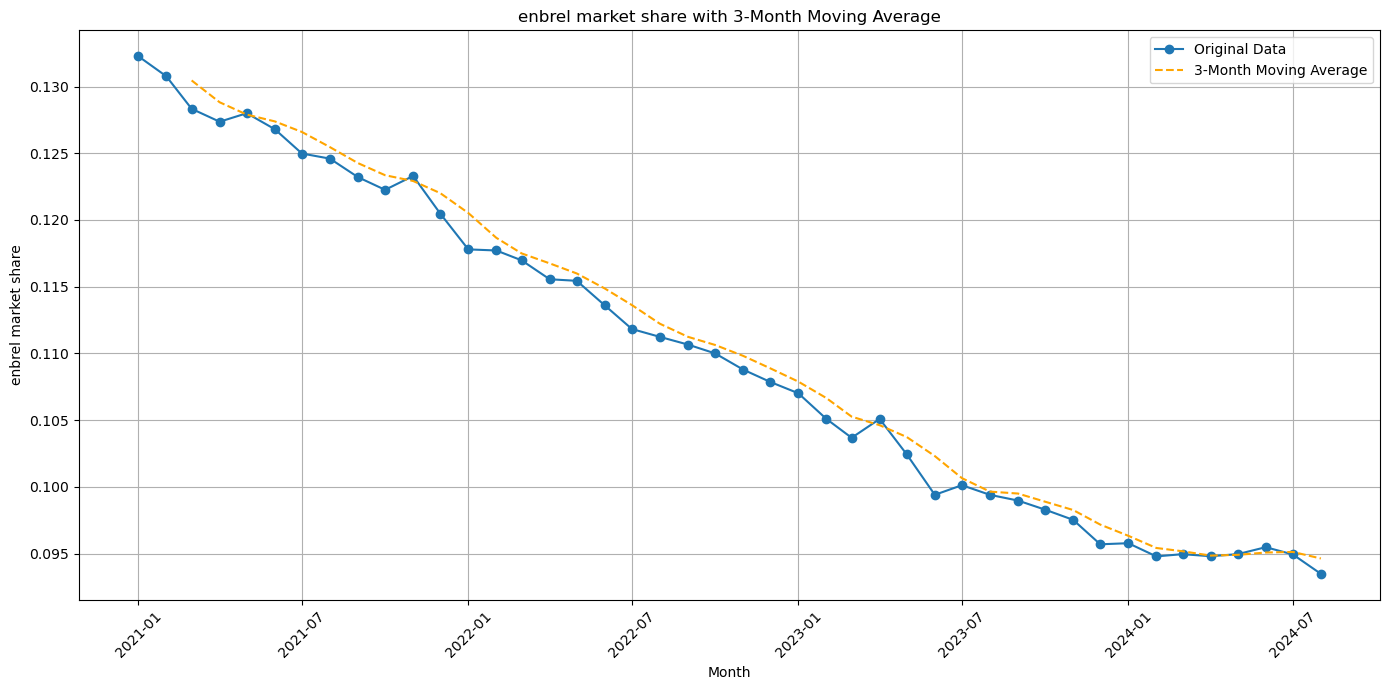

In [345]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from scipy.stats import zscore

# Load data - enbrel market share
data = pd.DataFrame({
    'Month': pd.to_datetime([
        '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10',
        '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08',
        '2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06',
        '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12', '2024-01', '2024-02', '2024-03', '2024-04',
        '2024-05', '2024-06', '2024-07', '2024-08']),
    'Value': [
        0.132275, 0.130772, 0.128333, 0.127365, 0.128003, 0.126804, 0.124983, 0.124598, 0.12321, 0.12226, 0.1233, 
        0.120481, 0.117798, 0.117715, 0.116977, 0.115559, 0.115441, 0.113599, 0.111829, 0.111239, 0.110663, 0.110002, 
        0.108788, 0.107863, 0.107016, 0.105095, 0.103678, 0.105089, 0.102432, 0.099403, 0.100125, 0.099401, 0.098973, 
        0.098291, 0.097528, 0.095695, 0.095777, 0.094788, 0.094956, 0.094801, 0.094956, 0.095478, 0.094935, 0.093481
    ]
})
# Set the 'Month' column as the index for easier manipulation
data.set_index('Month', inplace=True)

# Compute the autocorrelation function (ACF)
lag_acf = acf(data['Value'], nlags=24)

# Function to detect seasonality or outliers dynamically
def detect_seasonality_or_outlier(acf_values, data, threshold=0.2, min_lag=2, z_threshold=2.0):
    peaks = [i for i in range(min_lag, len(acf_values)) if acf_values[i] > threshold]
    if not peaks:
        return None, None

    peak_acf = max(peaks, key=lambda x: acf_values[x])

    # Group data by month and calculate mean
    monthly_means = data.groupby(data.index.month)['Value'].mean()

    # Calculate z-scores for monthly means to identify outliers
    monthly_zscores = zscore(monthly_means)

    # Check if any month is an outlier based on z-score threshold
    outlier_month = monthly_means.index[np.argmax(monthly_zscores)]
    if monthly_zscores.max() > z_threshold:
        # Return the month name instead of number
        return peak_acf, f"outlier in {pd.Timestamp(2024, outlier_month, 1).strftime('%B')}"

    # If no outliers, determine seasonality pattern
    seasonal_values = data['Value'][::peak_acf]
    if len(seasonal_values) < 2:
        return peak_acf, None

    seasonal_trend = "increase" if seasonal_values.diff().mean() > 0 else "decrease"
    return peak_acf, seasonal_trend

# Detect seasonality or outlier dynamically
seasonal_period, seasonal_trend = detect_seasonality_or_outlier(lag_acf, data)

# Function to calculate 3-month moving average of slopes for a given year
def moving_average_slopes(data, year, window=3):
    # Filter the data for the specified year
    data_year = data[data.index.year == year]
    
    # Calculate the slopes for each consecutive period in the selected year
    slopes = np.diff(data_year['Value'])
    
    # Calculate the moving average of the slopes
    ma_slopes = np.convolve(slopes, np.ones(window) / window, mode='valid')
    
    # Check if the slope of the moving average approaches zero
    if np.abs(ma_slopes.mean()) < 0.0001:
        ma_slope_trend = "The trend has stabilized since the beginning of the year"
    elif ma_slopes.mean() > 0:
        ma_slope_trend = "The trend has increased since the beginning of the year"
    else:
        ma_slope_trend = "The trend has decreased since the beginning of the year"
    
    return ma_slopes, ma_slope_trend

# Trend analysis and summary function
def trend_analysis(data, seasonal_period, seasonal_trend):
    x = np.arange(len(data))
    y = data['Value'].values
    slope = (y[-1] - y[0]) / (x[-1] - x[0])
    direction = "increasing" if slope > 0 else "decreasing" if slope < 0 else "stable"

    # Calculate total change from start to end
    total_change = y[-1] - y[0]
    
    slopes = [data['Value'].iloc[i] - data['Value'].iloc[i-1] for i in range(1, len(data))]
    max_increase = max(slopes)
    max_decrease = min(slopes)
    max_increase_periods = [(data.index[i].strftime('%B %Y'), data.index[i+1].strftime('%B %Y')) for i, slope in enumerate(slopes) if slope == max_increase]
    max_decrease_periods = [(data.index[i].strftime('%B %Y'), data.index[i+1].strftime('%B %Y')) for i, slope in enumerate(slopes) if slope == max_decrease]

    max_increase_periods_str = ', '.join([f"{start} to {end}" for start, end in max_increase_periods])
    max_decrease_periods_str = ', '.join([f"{start} to {end}" for start, end in max_decrease_periods])

    # Moving average calculation
    ma_window = 3  # 3-month moving average
    moving_avg = np.convolve(data['Value'].values, np.ones(ma_window) / ma_window, mode='valid')
    moving_avg_trend = (moving_avg[-1] - moving_avg[0]) / (len(moving_avg) - 1)
    ma_trend_direction = "upward" if moving_avg_trend > 0 else "downward" if moving_avg_trend < 0 else "stable"

    # Additional moving average slope analysis for the latest year dynamically
    latest_year = data.index.year.max()
    ma_slopes_latest, ma_slope_trend_latest = moving_average_slopes(data, year=latest_year)

    # Summary
    if seasonal_period:
        if seasonal_trend.startswith('outlier'):
            seasonal_summary = f"An outlier has been detected in {seasonal_trend.split()[-1]} with a significant pattern repeating every {seasonal_period} months."
        else:
            seasonal_summary = f"A seasonal pattern repeating every {seasonal_period} months has been detected, with a general {seasonal_trend} in trend."
    else:
        seasonal_summary = "No seasonal pattern was detected, indicating an outlier."

    summary = (
        f"\n\n****SUMMARY****\nBy examining these insights, we can conclude that the overall value trend is "
        f"{direction} by {total_change:.4f} from start to end. The 3-month moving average indicates a {ma_trend_direction} trend, highlighting the general direction "
        f"of the data.\n\nSignificant fluctuations are evident, with the largest increase observed between "
        f"{max_increase_periods_str} (slope: {max_increase:.4f}) and the largest "
        f"decrease from {max_decrease_periods_str} (slope: {max_decrease:.4f})."
        f"\n\nAdditionally, {seasonal_summary}\n\n"
        f"**Trend for {latest_year}:** {ma_slope_trend_latest}."
    )

    return summary

# Get the summary report
summary = trend_analysis(data, seasonal_period, seasonal_trend)
print(summary)

# Define ma_window before plotting
ma_window = 3  # 3-month moving average
moving_avg = np.convolve(data['Value'].values, np.ones(ma_window) / ma_window, mode='valid')

# Plot the data and moving average
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Value'], label='Original Data', marker='o')
plt.plot(data.index[ma_window-1:], moving_avg, label='3-Month Moving Average', linestyle='--', color='orange')
plt.title('enbrel market share with 3-Month Moving Average')
plt.xlabel('Month')
plt.ylabel('enbrel market share')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



****SUMMARY****
By examining these insights, we can conclude that the overall value trend is decreasing by -0.0113 from start to end. The 3-month moving average indicates a upward trend, highlighting the general direction of the data.

Significant fluctuations are evident, with the largest increase observed between December 2021 to January 2022 (slope: 0.0380) and the largest decrease from January 2023 to February 2023 (slope: -0.0322).

Additionally, An outlier has been detected in January with a significant pattern repeating every 12 months.

**Trend for 2024:** The trend has decreased since the beginning of the year.


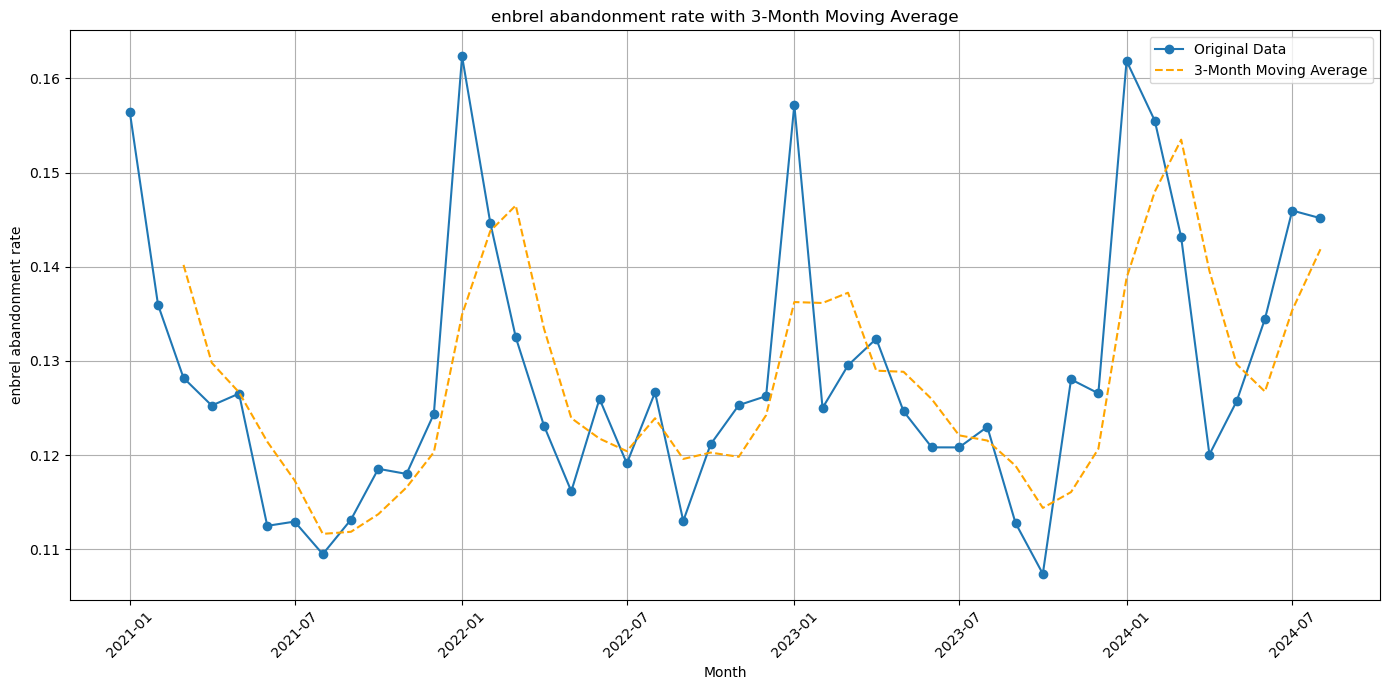

In [341]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from scipy.stats import zscore

# Load data - enbrel abandonment rate
data = pd.DataFrame({
    'Month': pd.to_datetime([
        '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10',
        '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08',
        '2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06',
        '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12', '2024-01', '2024-02', '2024-03', '2024-04',
        '2024-05', '2024-06', '2024-07', '2024-08']),
    'Value': [
        0.156423823, 0.135963011, 0.128205128, 0.125271150, 0.126541398, 0.112505005, 0.112956355, 0.109499233, 0.113170732,
        0.118557414, 0.118015808, 0.124376804, 0.162345433, 0.144664980, 0.132510480, 0.123129719, 0.116173435, 0.125983220,
        0.119126312, 0.126665804, 0.113022113, 0.121150730, 0.125315615, 0.126271532, 0.157178218, 0.125016732, 0.129538054,
        0.132361111, 0.124664022, 0.120833887, 0.120828539, 0.123008619, 0.112805330, 0.107410820, 0.128046262, 0.126567681,
        0.161849711, 0.155495318, 0.143121092, 0.120072434, 0.125740319, 0.134462968, 0.145966552, 0.145155064
    ]
})
# Set the 'Month' column as the index for easier manipulation
data.set_index('Month', inplace=True)

# Compute the autocorrelation function (ACF)
lag_acf = acf(data['Value'], nlags=24)

# Function to detect seasonality or outliers dynamically
def detect_seasonality_or_outlier(acf_values, data, threshold=0.2, min_lag=2, z_threshold=2.0):
    peaks = [i for i in range(min_lag, len(acf_values)) if acf_values[i] > threshold]
    if not peaks:
        return None, None

    peak_acf = max(peaks, key=lambda x: acf_values[x])

    # Group data by month and calculate mean
    monthly_means = data.groupby(data.index.month)['Value'].mean()

    # Calculate z-scores for monthly means to identify outliers
    monthly_zscores = zscore(monthly_means)

    # Check if any month is an outlier based on z-score threshold
    outlier_month = monthly_means.index[np.argmax(monthly_zscores)]
    if monthly_zscores.max() > z_threshold:
        # Return the month name instead of number
        return peak_acf, f"outlier in {pd.Timestamp(2024, outlier_month, 1).strftime('%B')}"

    # If no outliers, determine seasonality pattern
    seasonal_values = data['Value'][::peak_acf]
    if len(seasonal_values) < 2:
        return peak_acf, None

    seasonal_trend = "increase" if seasonal_values.diff().mean() > 0 else "decrease"
    return peak_acf, seasonal_trend

# Detect seasonality or outlier dynamically
seasonal_period, seasonal_trend = detect_seasonality_or_outlier(lag_acf, data)

# Function to calculate 3-month moving average of slopes for a given year
def moving_average_slopes(data, year, window=3):
    # Filter the data for the specified year
    data_year = data[data.index.year == year]
    
    # Calculate the slopes for each consecutive period in the selected year
    slopes = np.diff(data_year['Value'])
    
    # Calculate the moving average of the slopes
    ma_slopes = np.convolve(slopes, np.ones(window) / window, mode='valid')
    
    # Check if the slope of the moving average approaches zero
    if np.abs(ma_slopes.mean()) < 0.0001:
        ma_slope_trend = "The trend has stabilized since the beginning of the year"
    elif ma_slopes.mean() > 0:
        ma_slope_trend = "The trend has increased since the beginning of the year"
    else:
        ma_slope_trend = "The trend has decreased since the beginning of the year"
    
    return ma_slopes, ma_slope_trend

# Trend analysis and summary function
def trend_analysis(data, seasonal_period, seasonal_trend):
    x = np.arange(len(data))
    y = data['Value'].values
    slope = (y[-1] - y[0]) / (x[-1] - x[0])
    direction = "increasing" if slope > 0 else "decreasing" if slope < 0 else "stable"

    # Calculate total change from start to end
    total_change = y[-1] - y[0]
    
    slopes = [data['Value'].iloc[i] - data['Value'].iloc[i-1] for i in range(1, len(data))]
    max_increase = max(slopes)
    max_decrease = min(slopes)
    max_increase_periods = [(data.index[i].strftime('%B %Y'), data.index[i+1].strftime('%B %Y')) for i, slope in enumerate(slopes) if slope == max_increase]
    max_decrease_periods = [(data.index[i].strftime('%B %Y'), data.index[i+1].strftime('%B %Y')) for i, slope in enumerate(slopes) if slope == max_decrease]

    max_increase_periods_str = ', '.join([f"{start} to {end}" for start, end in max_increase_periods])
    max_decrease_periods_str = ', '.join([f"{start} to {end}" for start, end in max_decrease_periods])

    # Moving average calculation
    ma_window = 3  # 3-month moving average
    moving_avg = np.convolve(data['Value'].values, np.ones(ma_window) / ma_window, mode='valid')
    moving_avg_trend = (moving_avg[-1] - moving_avg[0]) / (len(moving_avg) - 1)
    ma_trend_direction = "upward" if moving_avg_trend > 0 else "downward" if moving_avg_trend < 0 else "stable"

    # Additional moving average slope analysis for the latest year dynamically
    latest_year = data.index.year.max()
    ma_slopes_latest, ma_slope_trend_latest = moving_average_slopes(data, year=latest_year)

    # Summary
    if seasonal_period:
        if seasonal_trend.startswith('outlier'):
            seasonal_summary = f"An outlier has been detected in {seasonal_trend.split()[-1]} with a significant pattern repeating every {seasonal_period} months."
        else:
            seasonal_summary = f"A seasonal pattern repeating every {seasonal_period} months has been detected, with a general {seasonal_trend} in trend."
    else:
        seasonal_summary = "No seasonal pattern was detected, indicating an outlier."

    summary = (
        f"\n\n****SUMMARY****\nBy examining these insights, we can conclude that the overall value trend is "
        f"{direction} by {total_change:.4f} from start to end. The 3-month moving average indicates a {ma_trend_direction} trend, highlighting the general direction "
        f"of the data.\n\nSignificant fluctuations are evident, with the largest increase observed between "
        f"{max_increase_periods_str} (slope: {max_increase:.4f}) and the largest "
        f"decrease from {max_decrease_periods_str} (slope: {max_decrease:.4f})."
        f"\n\nAdditionally, {seasonal_summary}\n\n"
        f"**Trend for {latest_year}:** {ma_slope_trend_latest}."
    )

    return summary

# Get the summary report
summary = trend_analysis(data, seasonal_period, seasonal_trend)
print(summary)

# Define ma_window before plotting
ma_window = 3  # 3-month moving average
moving_avg = np.convolve(data['Value'].values, np.ones(ma_window) / ma_window, mode='valid')

# Plot the data and moving average
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Value'], label='Original Data', marker='o')
plt.plot(data.index[ma_window-1:], moving_avg, label='3-Month Moving Average', linestyle='--', color='orange')
plt.title('enbrel abandonment rate with 3-Month Moving Average')
plt.xlabel('Month')
plt.ylabel('enbrel abandonment rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



****SUMMARY****
By examining these insights, we can conclude that the overall value trend is increasing by 202107.8339 from start to end. The 3-month moving average indicates a upward trend, highlighting the general direction of the data.

Significant fluctuations are evident, with the largest increase observed between December 2023 to January 2024 (slope: 58285.7065) and the largest decrease from August 2024 to September 2024 (slope: -172299.8533).

Additionally, A seasonal pattern repeating every 2 months has been detected, with a general increase in trend.

**Trend for 2024:** The trend has increased since the beginning of the year.


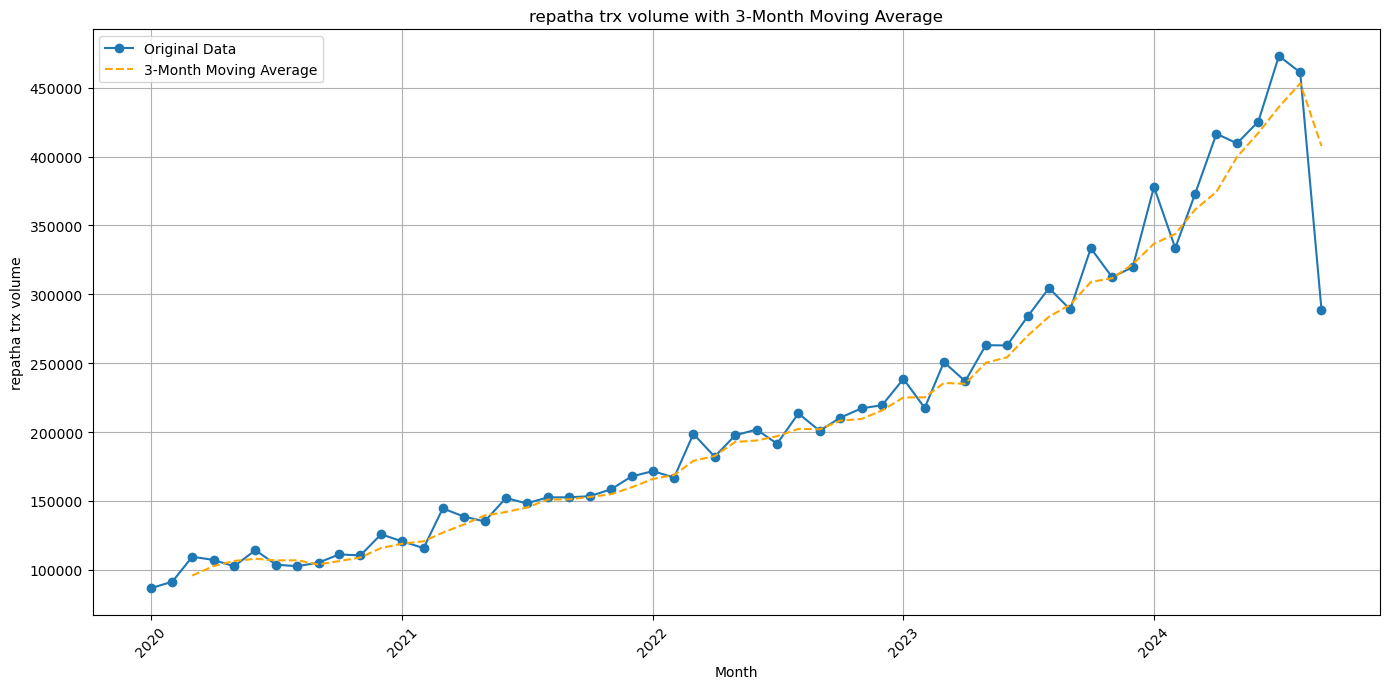

In [343]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from scipy.stats import zscore

# Load data - repatha trx volume
data = pd.DataFrame({
    'Month': pd.to_datetime([
        '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10',
        '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08',
        '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06',
        '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03', '2023-04',
        '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12', '2024-01', '2024-02',
        '2024-03', '2024-04', '2024-05', '2024-06', '2024-07', '2024-08', '2024-09']),
    'Value': [
        86666.32398, 91327.55093, 109431.243, 107146.4896, 102500.5637, 114261.9447, 103674.1987, 102571.6994, 
        105177.0645, 111121.7542, 110434.5538, 125723.6292, 120606.5154, 115702.0196, 144530.9986, 138549.9833, 
        135103.9182, 152091.1209, 148180.1968, 152539.8188, 152581.1242, 153407.0207, 158389.9745, 167722.2655, 
        171591.0966, 166968.4475, 198642.599, 182092.6936, 197628.7729, 201778.9983, 191476.7093, 213494.1797, 
        200836.1643, 210392.6802, 217196.0751, 219453.2711, 238561.2165, 217462.5759, 250751.3461, 236890.0437, 
        263048.9903, 262831.7221, 283909.8215, 304450.6739, 288974.0017, 333455.8712, 312402.4141, 319684.8429, 
        377970.5494, 333553.3237, 373030.2359, 416520.7599, 409574.4677, 425385.0457, 473025.6583, 461074.0112, 
        288774.1579
    ]
})
# Set the 'Month' column as the index for easier manipulation
data.set_index('Month', inplace=True)

# Compute the autocorrelation function (ACF)
lag_acf = acf(data['Value'], nlags=24)

# Function to detect seasonality or outliers dynamically
def detect_seasonality_or_outlier(acf_values, data, threshold=0.2, min_lag=2, z_threshold=2.0):
    peaks = [i for i in range(min_lag, len(acf_values)) if acf_values[i] > threshold]
    if not peaks:
        return None, None

    peak_acf = max(peaks, key=lambda x: acf_values[x])

    # Group data by month and calculate mean
    monthly_means = data.groupby(data.index.month)['Value'].mean()

    # Calculate z-scores for monthly means to identify outliers
    monthly_zscores = zscore(monthly_means)

    # Check if any month is an outlier based on z-score threshold
    outlier_month = monthly_means.index[np.argmax(monthly_zscores)]
    if monthly_zscores.max() > z_threshold:
        # Return the month name instead of number
        return peak_acf, f"outlier in {pd.Timestamp(2024, outlier_month, 1).strftime('%B')}"

    # If no outliers, determine seasonality pattern
    seasonal_values = data['Value'][::peak_acf]
    if len(seasonal_values) < 2:
        return peak_acf, None

    seasonal_trend = "increase" if seasonal_values.diff().mean() > 0 else "decrease"
    return peak_acf, seasonal_trend

# Detect seasonality or outlier dynamically
seasonal_period, seasonal_trend = detect_seasonality_or_outlier(lag_acf, data)

# Function to calculate 3-month moving average of slopes for a given year
def moving_average_slopes(data, year, window=3):
    # Filter the data for the specified year
    data_year = data[data.index.year == year]
    
    # Calculate the slopes for each consecutive period in the selected year
    slopes = np.diff(data_year['Value'])
    
    # Calculate the moving average of the slopes
    ma_slopes = np.convolve(slopes, np.ones(window) / window, mode='valid')
    
    # Check if the slope of the moving average approaches zero
    if np.abs(ma_slopes.mean()) < 0.0001:
        ma_slope_trend = "The trend has stabilized since the beginning of the year"
    elif ma_slopes.mean() > 0:
        ma_slope_trend = "The trend has increased since the beginning of the year"
    else:
        ma_slope_trend = "The trend has decreased since the beginning of the year"
    
    return ma_slopes, ma_slope_trend

# Trend analysis and summary function
def trend_analysis(data, seasonal_period, seasonal_trend):
    x = np.arange(len(data))
    y = data['Value'].values
    slope = (y[-1] - y[0]) / (x[-1] - x[0])
    direction = "increasing" if slope > 0 else "decreasing" if slope < 0 else "stable"

    # Calculate total change from start to end
    total_change = y[-1] - y[0]
    
    slopes = [data['Value'].iloc[i] - data['Value'].iloc[i-1] for i in range(1, len(data))]
    max_increase = max(slopes)
    max_decrease = min(slopes)
    max_increase_periods = [(data.index[i].strftime('%B %Y'), data.index[i+1].strftime('%B %Y')) for i, slope in enumerate(slopes) if slope == max_increase]
    max_decrease_periods = [(data.index[i].strftime('%B %Y'), data.index[i+1].strftime('%B %Y')) for i, slope in enumerate(slopes) if slope == max_decrease]

    max_increase_periods_str = ', '.join([f"{start} to {end}" for start, end in max_increase_periods])
    max_decrease_periods_str = ', '.join([f"{start} to {end}" for start, end in max_decrease_periods])

    # Moving average calculation
    ma_window = 3  # 3-month moving average
    moving_avg = np.convolve(data['Value'].values, np.ones(ma_window) / ma_window, mode='valid')
    moving_avg_trend = (moving_avg[-1] - moving_avg[0]) / (len(moving_avg) - 1)
    ma_trend_direction = "upward" if moving_avg_trend > 0 else "downward" if moving_avg_trend < 0 else "stable"

    # Additional moving average slope analysis for the latest year dynamically
    latest_year = data.index.year.max()
    ma_slopes_latest, ma_slope_trend_latest = moving_average_slopes(data, year=latest_year)

    # Summary
    if seasonal_period:
        if seasonal_trend.startswith('outlier'):
            seasonal_summary = f"An outlier has been detected in {seasonal_trend.split()[-1]} with a significant pattern repeating every {seasonal_period} months."
        else:
            seasonal_summary = f"A seasonal pattern repeating every {seasonal_period} months has been detected, with a general {seasonal_trend} in trend."
    else:
        seasonal_summary = "No seasonal pattern was detected, indicating an outlier."

    summary = (
        f"\n\n****SUMMARY****\nBy examining these insights, we can conclude that the overall value trend is "
        f"{direction} by {total_change:.4f} from start to end. The 3-month moving average indicates a {ma_trend_direction} trend, highlighting the general direction "
        f"of the data.\n\nSignificant fluctuations are evident, with the largest increase observed between "
        f"{max_increase_periods_str} (slope: {max_increase:.4f}) and the largest "
        f"decrease from {max_decrease_periods_str} (slope: {max_decrease:.4f})."
        f"\n\nAdditionally, {seasonal_summary}\n\n"
        f"**Trend for {latest_year}:** {ma_slope_trend_latest}."
    )

    return summary

# Get the summary report
summary = trend_analysis(data, seasonal_period, seasonal_trend)
print(summary)

# Define ma_window before plotting
ma_window = 3  # 3-month moving average
moving_avg = np.convolve(data['Value'].values, np.ones(ma_window) / ma_window, mode='valid')

# Plot the data and moving average
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Value'], label='Original Data', marker='o')
plt.plot(data.index[ma_window-1:], moving_avg, label='3-Month Moving Average', linestyle='--', color='orange')
plt.title('repatha trx volume with 3-Month Moving Average')
plt.xlabel('Month')
plt.ylabel('repatha trx volume')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()